In [1]:
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mglearn

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 第5章 模型评估与改进
本章重点介绍监督方法，包括回归与分类，因为在无监督学习中，模型评估与选择通常是一个非常定性的过程。

到目前为止，为了评估我们的监督模型，我们使用`train_test_split`函数将数据集划分为训练集和测试集，在训练集上调用`fit`方法来构建模型，在测试集上用`score`方法来评估这个模型。下面是这个过程的一个示例：

In [2]:
# 创建一个模拟数据集
X, y = make_blobs(random_state=0)
# 将数据和标签划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 将模型实例化，并用它来拟合训练集
logreg = LogisticRegression().fit(X_train, y_train)
# 在测试集上评估该模型
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


我们从两个方面进行模型评估。首先介绍交叉验证，然后讨论评估分类和回归性能的方法，其中前者是一种更可靠的评估泛化性能的方法，后者是在默认度量(`score`方法给出的精度和$R^2$）之外的方法。

我们还将讨论网格搜索，这是一种调节监督模型参数以获得最佳泛化性能的有效方法。

## 5.1 交叉验证
`交叉验证`(cross-validation)是一种评估泛化性能的统计学方法。在交叉验证中，数据被多次划分，并且需要训练多个模型。最常用的交叉验证是`k折交叉验证`(k-fold cross-validation)，其中`k`是由用户指定的数字，通常取5或10。在执行5折交叉验证时，首先将数据划分为大致相等的5份，每一部分叫作折(fold)，接下来训练一系列模型，即使用第1折作为测试集、其他折(2~5)作为训练集来训练第一个模型；之后使用2折作为测试集，1、3、4、5折中的数据作为训练集，以此类推，每一次都要计算精度。最后我们得到了5个精度值。整个过程如`图5-1`所示：
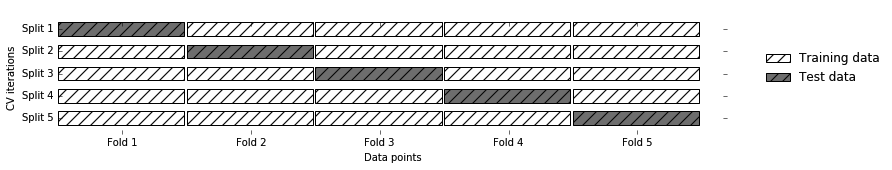

### 5.1.1 scikit-learn中的交叉验证
`scikit-learn`是利用`model_selection`模块中的`cross_val_score`函数来实现交叉验证的。`cross_val_score`函数的参数是我们想要评估的模型、训练数据与真实标签：

In [3]:
iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


可以修改`cv`参数来改变折数：

In [4]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


总结交叉验证精度的一种常用方法是计算平均值：

In [5]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


我们从交叉验证平均值中得出结论，预计模型的平均精度约为$96\%$。观察5折交叉验证得到的所有精度值可以发现，折与折之间的精度有较大的变化，这可能意味着模型强烈依赖于将某个折用于训练，但也可能只是因为数据集的数据量太小。

### 5.1.2 交叉验证的优点
使用交叉验证具有下列优点：
1. `train_test_split`对数据进行随机划分。想象一下，在随机划分数据时我们很“幸运”，所有难以分类的样例都在训练集中。在这种情况下，测试集将仅包含“容易分类的”样例，并且测试集精度会高得不切实际。相反，如果我们“不够幸运”，则可能随机地将所有难以分类的样例都放在测试集中，因此得到一个不切实际的低分数。但如果使用交叉验证，每个样例都会刚好在测试集中出现一次：每个样例位于一个折中，而每个折都在测试集中出现一次。因此，模型需要对数据集中所有样本的泛化能力都很好，才能让所有的交叉验证得分(及其平均值)都很高
2. 对数据进行多次划分，还可以提供我们的模型对训练集选择的敏感性信息。对于`iris数据集`，我们观察到精度在$90\%$到$100\%$之间，这是一个不小的范围，它告诉我们将模型应用于新数据时在最坏情况和最好情况下的可能表现
3. 与数据的单次划分相比，交叉验证的另一个优点是我们对数据的使用更加高效。在使用`train_test_split`时，我们通常将$75\%$的数据用于训练，$25\%$的数据用于评估。在使用5折交叉验证时，在每次迭代中我们可以使用$80\%$的数据来拟合模型。在使用10折交叉验证时，我们可以使用$90\%$的数据来拟合模型。更多的数据通常可以得到更为精确的模型

交叉验证的主要缺点是增加了计算成本。

> 重要的是要记住，交叉验证不是一种构建可应用于新数据的模型的方法。交叉验证不会返回一个模型。在调用`cross_val_score`时，内部会构建多个模型，但交叉验证的目的只是评估给定算法在特定数据集上训练后的泛化性能好坏。

### 5.1.3 分层k折交叉验证和其他策略
将数据集划分为$k$折时，从数据的前$\displaystyle \frac{1}{k}$开始划分，这可能并不总是一个好主意。例如，我们来看一下`iris数据集`：

In [6]:
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


如你所见，数据的前三分之一是类别$0$，中间三分之一是类别$1$，最后三分之一是类别$2$。想象一下在这个数据集上进行$3$折交叉验证。第$1$折只包含类别$0$，所以在数据的第一次划分中，测试集将只包含类别$0$，而训练集只包含类别$1$和$2$。由于在$3$次划分中训练集和测试集中的类别都不相同，因此这个数据集上的$3$折交叉验证精度为$0$。

因此，`scikit-learn`在分类问题中不使用这种策略，而是使用`分层k折交叉验证(stratified k-fold cross-validation)`。在`分层交叉验证`中，我们划分数据，使每个折中类别之间的比例与整个数据集中的比例相同，如`图5-2`所示：
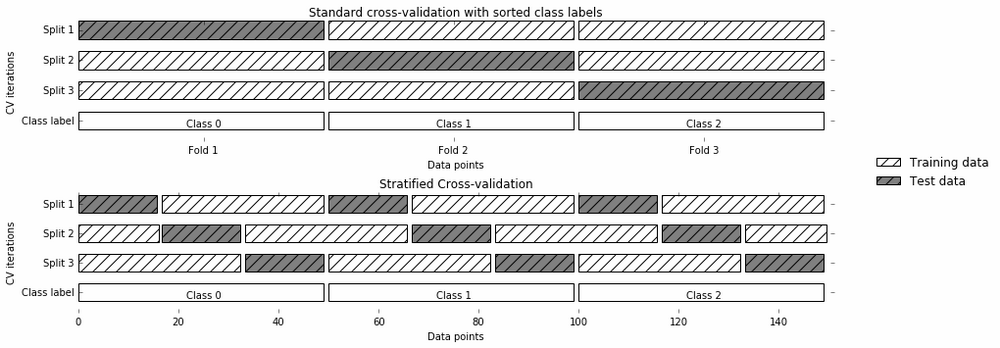

**对于回归问题，`scikit-learn`默认使用`标准k折交叉验证`。也可以尝试让每个折表示回归目标的不同取值，但这并不是一种常用的策略，也会让大多数用户感到意外。**

#### 5.1.3.1 对交叉验证的更多控制
我们之前看到，可以利用`cv参数`来调节`cross_val_score`所使用的折数。但`scikit-learn`允许提供一个`交叉验证分离器`(cross-validation splitter)作为`cv参数`，来对数据划分过程进行更精细的控制。

对于大多数使用场景而言，回归问题默认的`k折交叉验证`与分类问题的`分层k折交叉验证`的表现都很好，但有些情况下你可能希望使用不同的策略。比如说，我们想要在一个分类数据集上使用`标准k折交叉验证`来重现别人的结果。为了实现这一点，我们首先必须从`model_selection`模块中导入`KFold`分离器类，并用我们想要使用的折数来将其实例化：

In [7]:
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         0.93333333 0.43333333 0.96666667 0.43333333]


通过这种方法可以验证，在`iris数据集`上使用`标准3折交叉验证`是一个非常糟糕的主意：

In [8]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


解决这个问题的另一种方法是打乱样本标签的排序来代替分层。可以通过将`KFold`的`shuffle`参数设为`True`来实现这一点。我们可以固定`random_state`以获得可重复的打乱结果：

In [9]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.9  0.96 0.96]


#### 5.1.3.2 留一法交叉验证
可以将留一法(leave-one-out)交叉验证看作是每折只包含单个样本的k折交叉验证。对于每次划分，你选择单个数据点作为测试集。这种方法可能非常耗时，特别是对于大型数据集来说，但在小型数据集上有时可以给出更好的估计结果：

In [10]:
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


#### 5.1.3.3 打乱划分交叉验证
在`打乱划分交叉验证`(shuffle-split cross-validation)中，每次划分为训练集取样`train_size`个点，为测试集取样`test_size`个(不相交的)点。将这一划分方法重复`n_iter`次。`图5-3`显示的是对包含$10$个点的数据集运行$4$次迭代划分，每次的训练集包含$5$个点，测试集包含$2$个点(可以将`train_size`和`test_size`设为整数来表示这两个集合的绝对大小，也可以设为浮点数来表示占整个数据集的比例)：
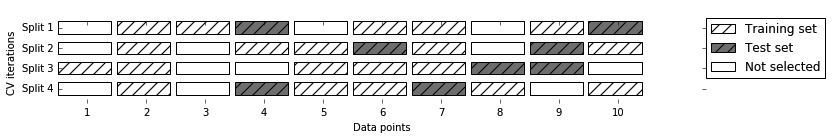

打乱划分交叉验证可以在训练集和测试集大小之外独立控制迭代次数。它还允许在每次迭代中仅使用部分数据，这可以通过设置`train_size`与`test_size`之和不等于1来实现。用这种方法对数据进行二次采样可能对大型数据上的试验很有用。

`ShuffleSplit`还有一种分层的形式，其名称为`StratifiedShuffleSplit`，它可以为分类任务提供更可靠的结果。

下面的代码使用`ShuffleSplit`和`StratifiedShuffleSplit`将数据集划分为$50\%$的训练集和$50\%$的测试集，共运行$10$次迭代：

In [11]:
ss = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=ss)
print("ShuffleSplit CV scores          : {}".format(scores.mean()))

sss = StratifiedShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=sss)
print("StratifiedShuffleSplit CV scores: {}".format(scores.mean()))

ShuffleSplit CV scores          : 0.9093333333333333
StratifiedShuffleSplit CV scores: 0.9480000000000001


#### 5.1.3.4 分组交叉验证
另一种非常常见的交叉验证适用于数据中的分组高度相关时。比如你想构建一个从人脸图片中识别情感的系统，并且收集了$100$个人的照片的数据集，其中每个人都进行了多次拍摄，分别展示了不同的情感。我们的目标是构建一个分类器，能够正确识别未包含在数据集中的人的情感。你可以使用默认的分层交叉验证来度量分类器的性能。但是这样的话，同一个人的照片可能会同时出现在训练集和测试集中。对于分类器而言，检测训练集中出现过的人脸情感比全新的人脸要容易得多。因此，为了准确评估模型对新的人脸的泛化能力，我们必须确保训练集和测试集中包含不同人的图像。

为了实现这一点，我们可以使用`GroupKFold`，它以`groups`数组作为参数，可以用来说明照片中对应的是哪个人。这里的`groups`数组表示数据中的分组，在创建训练集和测试集的时候不应该将其分开，也不应该与类别标签弄混。

下面的示例用到了一个由`groups`数组指定分组的模拟数据集。这个数据集包含$12$个数据点，且对于每个数据点，`groups`指定了该点所属的分组。一共分成$4$个组，前$3$个样本属于第一组，接下来的$4$个样本属于第二组，以此类推：

In [12]:
# 创建模拟数据集
X, y = make_blobs(n_samples=12, random_state=0)
# 假设前3个样本属于同一组，接下来的4个属于同一组，以此类推
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75       0.8        0.66666667]


样本不需要按分组进行排序，我们这么做只是为了便于说明。基于这些标签计算得到的划分如`图5-4`所示：
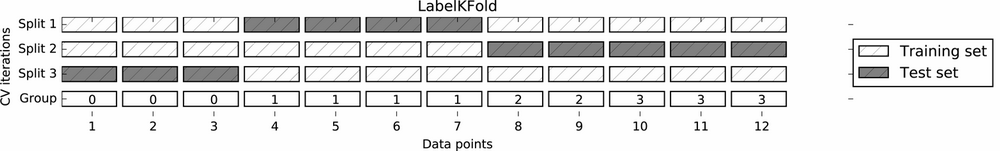

`scikit-learn`中还有很多交叉验证的划分策略，适用于更多的使用场景。你可以在[页面](http://scikit-learn.org/stable/modules/cross_validation.html)查看。但标准的`KFold`、`StratifiedKFold`和`GroupKFold`是目前最常用的几种。

## 5.2 网格搜索
现在我们知道了如果评估一个模型的泛化能力，下面继续学习通过调参来提升模型的泛化性能。

找到一个模型的重要参数(提供最佳泛化性能的参数)的取值是一项棘手的任务，但对于几乎所有模型和数据集来说都是必要的。由于这项任务如此常见，所以`scikit-learn`中有一些标准方法可以帮你完成。最常用的方法就是`网格搜索`(grid search)，它主要是指尝试我们关心的参数的所有可能组合。

考虑一个具有`RBF`(径向基函数)核的`核SVM`的例子，它有$2$个重要参数：核宽度`gamma`和正则化参数`C`。假设我们希望尝试`C`的取值为0.001、0.01、0.1、1、10和100，`gamma`也取这$6$个值，总共有$36$种参数组合。所有可能的组合组成了`SVM`的参数设置表(网格)。

### 5.2.1 简单网格搜索
我们可以实现一个简单的网格搜索：

In [13]:
# 简单的网格搜索实现
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
print("Size of training set: {}\nSize of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 对每种参数组合都训练一个SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 在测试集上评估SVC
        score = svm.score(X_test, y_test)
        # 如果我们得到了更高的分数，则保存该分数和对应的参数
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112
Size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### 5.2.2 参数过拟合的风险与验证集
看到这个结果，我们可能忍不住要报告，我们找到了一个在数据集上精度达到$97\%$的模型。然而，这种说法可能过于乐观了(或者就是错的)，其原因如下：我们尝试了许多不同的参数，并选择了在测试集上精度最高的那个，但这个精度不一定能推广到新数据上。由于我们使用测试数据进行调参，所以不能再用它来评估模型的好坏。我们最开始需要将数据划分为训练集和测试集也是因为这个原因。我们需要一个独立的数据集来进行评估，一个在创建模型时没有用到的数据集。

为了解决这个问题，一种方法是再次划分数据，这样我们得到$3$个数据集：用于构建模型的训练集、用于选择模型参数的验证集、用于评估所选参数性能的测试集。`图5-5`给出了这$3$个集合的图示：
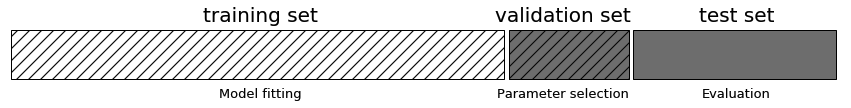

利用验证集选定最佳参数之后，我们可以利用找到的参数设置重新构建一个模型，但是要同时在训练数据和验证数据上进行训练。这样我们可以利用尽可能多的数据来构建模型。其实现如下所示：

In [14]:
# 将数据划分为训练+验证集与测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# 将训练+验证集划分为训练集与验证集
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Size of training set: {}\nSize of validation set: {}\nSize of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 对每种参数组合都训练一个SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 在验证集上评估SVC
        score = svm.score(X_valid, y_valid)
        # 如果我们得到了更高的分数，则保存该分数和对应的参数
        if score > best_score:
           best_score = score
           best_parameters = {'C': C, 'gamma': gamma}

# 在训练+验证集上重新构建一个模型，并在测试集上进行评估
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84
Size of validation set: 28
Size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


验证集上的最高分数是$96%$，比之前略低，可能是因为我们使用了更少的数据来训练模型。测试集上的分数(这个分数实际反映了模型的泛化能力)更低，因此，我们只能声称对$92%$的新数据正确分类，而不是我们之前认为的$97%$！

训练集、验证集和测试集之间的区别对于在实践中应用机器学习方法至关重要。任何根据测试集精度所做的选择都会将测试集的信息“泄漏”到模型中。因此，保留一个单独的测试集是很重要的，它仅用于最终评估。好的做法是利用训练集和验证集的组合完成所有的探索性分析与模型选择，并保留测试集用于最终评估。严格来说，在测试集上对不止一个模型进行评估并选择更好的那个，将会导致对模型精度过于乐观的估计。

### 5.2.3 带交叉验证的网格搜索
虽然将数据划分为训练集、验证集和测试集的方法是可行的，也相对常用，但这种方法对数据的划分方法相当敏感。为了得到对泛化性能的更好估计，我们可以使用交叉验证来评估每种参数组合的性能，而不是仅将数据单次划分为训练集与验证集。这种方法用代码表示如下：

In [15]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 对于每种参数组合都训练一个SVC
        svm = SVC(gamma=gamma, C=C)
        # 执行交叉验证
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 计算交叉验证平均精度
        score = np.mean(scores)
        # 如果我们得到了更高的分数，则保存该分数和对应的参数
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# 在训练+验证集上重新构建一个模型
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

上面的`5折交叉验证`需要训练$36*5 = 180$个模型，使用交叉验证的主要缺点就是训练所有这些模型所需花费的时间。

**如前所述，交叉验证是在特定数据集上对给定算法进行评估的一种方法。但它通常与网格搜索等参数搜索方法结合使用。因此，许多人使用交叉验证(cross-validation)这一术语来通俗地指代带交叉验证的网格搜索。**

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


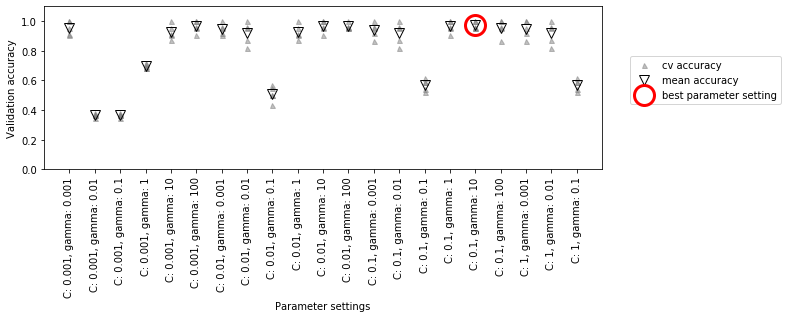

In [16]:
mglearn.plots.plot_cross_val_selection()
plt.show()

划分数据、运行网格搜索并评估最终参数整个过程如`图5-7`所示：

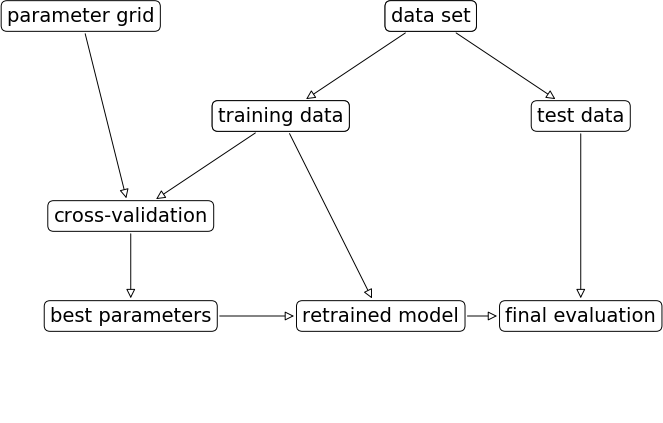

In [17]:
mglearn.plots.plot_grid_search_overview()
plt.show()

`scikit-learn`提供了`GridSearchCV`类实现带交叉验证的网格搜索，它以估计器(estimator)的形式实现了这种方法。要使用`GridSearchCV`类，你首先需要用一个字典指定要搜索的参数。然后`GridSearchCV`会执行所有必要的模型拟合。字典的键是我们要调节的参数名称，字典的值是我们想要尝试的参数设置：

In [18]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


`grid_search`对象的行为就像是一个分类器，可以对它调用标准的`fit`、`predict`和`score`方法。我们在调用`fit`时，它会对`param_grid`指定的每种参数组合都运行交叉验证。

> 用另一个估计器创建的`scikit-learn`估计器被称为元估计器(meta-estimator)。GridSearchCV 是最常用的元估计器，但后面我们将看到更多

拟合`GridSearchCV`对象不仅会搜索最佳参数，还会利用得到最佳交叉验证性能的参数在整个训练数据集上自动拟合一个新模型。因此，fit 完成的工作相当于本节开头的代码结果。`GridSearchCV`类提供了一个非常方便的接口，可以用`predict`和`score`方法来访问重新训练过的模型。

利用交叉验证选择参数，我们实际上找到了一个在测试集上精度为$97\%$的模型。我们没有使用测试集来选择参数。我们找到的参数保存在`best_params_`属性中，而交叉验证最佳精度(对于这种参数设置，不同划分的平均精度)保存在`best_score_`中：

In [19]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


> 注意：不要将`best_score_`与模型在测试集上调用`score`方法计算得到的泛化性能弄混。使用`score`方法(或者对`predict`方法的输出进行评估)采用的是在整个训练集上训练的模型。而`best_score_`属性保存的是交叉验证的平均精度，是在训练集上进行交叉验证得到的

`best_estimator_`属性保存最佳参数对应的模型，它是在整个训练集上训练得到的：

In [20]:
grid_search.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

由于`grid_search`本身具有`predict`和`score`方法，所以不需要使用`best_estimator_`来进行预测或评估模型。

#### 5.2.3.1 分析交叉验证的结果
将交叉验证的结果可视化通常有助于理解模型泛化能力对所搜索参数的依赖关系。由于运行网格搜索的计算成本相当高，所以通常最好从相对比较稀疏且较小的网格开始搜索。然后我们可以检查交叉验证网格搜索的结果，可能也会扩展搜索范围。网格搜索的结果可以在`cv_results_`属性中找到，它是一个字典，其中保存了搜索的所有内容。你可以在下面的输出中看到，它里面包含许多细节，最好将其转换成`pandas`数据框后再查看：

In [21]:
# 转换为DataFrame（数据框）
results = pd.DataFrame(grid_search.cv_results_)
# 显示前5行
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001051,0.000101,0.000465,0.000103,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000946,0.000031,0.000411,0.000008,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000978,0.000043,0.000416,0.000011,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.000991,0.000038,0.000422,0.000022,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.001035,0.000035,0.000416,0.000011,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


`results`中每一行对应一种特定的参数设置。对于每种参数设置，交叉验证所有划分的结果都被记录下来，所有划分的平均值和标准差也被记录下来。由于我们搜索的是一个二维参数网格，所以最适合用热图可视化(见`图5-8`)。我们首先提取平均验证分数，然后改变分数数组的形状，使其坐标轴分别对应于`C`和`gamma`：

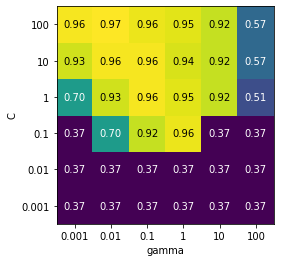

In [22]:
scores = np.array(results.mean_test_score).reshape(6, 6)

# 对交叉验证平均分数作图
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
plt.show()

热图中的每个点对应于运行一次交叉验证以及一种特定的参数设置。颜色表示交叉验证的精度：浅色表示高精度，深色表示低精度。你可以看到，`SVC`对参数设置非常敏感。我们可以从这张图中看出以下几点。首先，我们调节的参数对于获得良好的性能非常重要。两个参数(`C`和`gamma`)都很重要。此外，在我们选择的参数范围中也可以看到输出发生了显著的变化。同样重要的是要注意，参数的范围要足够大：每个参数的最佳取值不能位于图像的边界上。

下面我们来看几张图(见`图5-9`)，其结果不那么理想，因为选择的搜索范围不合适：

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


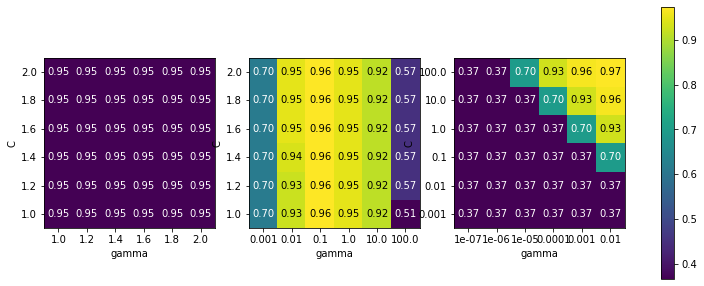

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear  = {'C':np.linspace(1, 2, 6), 'gamma':np.linspace(1, 2, 6)}
param_grid_one_log = {'C':np.linspace(1, 2, 6), 'gamma':np.logspace(-3, 2, 6)}
param_grid_range   = {'C':np.logspace(-3, 2, 6),'gamma':np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # 对交叉验证平均分数作图
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())
plt.show()

分析上图可以看到：
- 第1张图没有显示任何变化，整个参数网格的颜色相同，这是由参数$C$和$gamma$不正确的缩放以及不正确的范围造成的。但如果对于不同的参数设置都看不到精度的变化，也可能是因为这个参数根本不重要。通常最好在开始时尝试非常极端的值，以观察改变参数是否会导致精度发生变化
- 第2张图显示的是垂直条形模式。这表示只有$gamma$的设置对精度有影响。这可能意味着$gamma$参数的搜索范围是我们所关心的，而$C$参数并不是，也可能意味着$C$参数并不重要
- 第3张图中$C$和$gamma$对应的精度都有变化。但可以看到，在图像的整个左下角都没有发生什么有趣的事情。我们在后面的网格搜索中可以不考虑非常小的值。最佳参数设置出现在右上角。由于最佳参数位于图像的边界，所以我们可以认为，在这个边界之外可能还有更好的取值，我们可能希望改变搜索范围以包含这一区域内的更多参数

基于交叉验证分数来调节参数网格是非常好的，也是探索不同参数的重要性的好方法。但是，你不应该在最终测试集上测试不同的参数范围——前面说过，只有确切知道了想要使用的模型，才能对测试集进行评估。

#### 5.2.3.2 在非网格的空间中搜索
在某些情况下，尝试所有参数的所有可能组合并不是一个好主意。例如，`SVC`有一个`kernel`参数，根据所选择的`kernel`，其他参数也是与之相关的。如果`linear`，那么模型是线性的，只会用到`C`参数；如果选择`rbf`，则需要使用`C`和`gamma`两个参数。在这种情况下，搜索`C`、`gamma`和`kernel`所有可能的组合没有意义。为了处理这种“条件”参数，`GridSearchCV`的`param_grid`可以是字典组成的列表(a list of dictionaries)。列表中的每个字典可扩展为一个独立的网格。包含内核与参数的网格搜索可能如下所示:

In [24]:
param_grid = [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


我们再次查看`cv_results_`，正如所料，如果选择`linear`，那么只有`C`是变化的：

In [25]:
results = pd.DataFrame(grid_search.cv_results_)
# 我们给出的是转置后的表格，这样更适合页面显示：
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00100856,0.000955868,0.000987291,0.000948715,0.000987768,0.00100112,0.000953579,0.000995874,0.000956392,0.000989294,...,0.000582743,0.000732231,0.00125804,0.00128431,0.000757551,0.000714111,0.000633192,0.000577402,0.00059247,0.000595474
std_fit_time,8.07998e-05,3.33041e-05,9.25924e-05,1.7984e-05,3.20366e-05,1.93193e-05,4.48203e-05,0.000104208,2.80685e-05,5.33224e-05,...,1.51462e-05,2.06792e-05,4.63388e-05,4.5342e-05,3.39756e-05,4.17001e-05,6.20921e-05,2.80157e-05,2.42518e-05,3.06227e-05
mean_score_time,0.000490284,0.000414658,0.000412607,0.000445271,0.000445414,0.000468683,0.00041666,0.000414562,0.000447464,0.000417185,...,0.0003901,0.000372934,0.000425005,0.000445557,0.000381184,0.000394583,0.000388575,0.000354385,0.000353718,0.00038147
std_score_time,8.45737e-05,1.15582e-05,9.9402e-06,3.81853e-05,4.24571e-05,8.21103e-05,1.07364e-05,7.79071e-06,4.88925e-05,6.42298e-06,...,4.30749e-05,8.20714e-06,3.11899e-05,2.39899e-05,1.93054e-05,4.38755e-05,1.74423e-05,1.37711e-05,1.57909e-05,3.71183e-05
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.521739,0.347826,0.826087,0.913043,0.956522,1,1


#### 5.2.3.3 使用不同的交叉验证策略进行网格搜索
`GridSearchCV`对分类问题默认使用`分层k折交叉验证`，对回归问题默认使用`k折交叉验证`。可以传入任何交叉验证分离器作为`GridSearchCV`的`cv`参数。特别地，如果只想将数据单次划分为训练集和验证集，你可以使用`ShuffleSplit`或`StratifiedShuffleSplit`，并设置$n\_iter=1$。这对于非常大的数据集或非常慢的模型可能会有帮助。

##### 嵌套交叉验证
在前面的例子中，我们先介绍了将数据单次划分为训练集、验证集与测试集，然后介绍了先将数据划分为训练集和测试集，再在训练集上进行交叉验证。但前面在使用`GridSearchCV`时，我们仍然将数据单次划分为训练集和测试集，这可能会导致结果不稳定，也让我们过于依赖数据的此次划分。我们可以再深入一点，不是只将原始数据一次划分为训练集和测试集，而是使用交叉验证进行多次划分，这就是所谓的嵌套交叉验证(nested cross-validation)。在嵌套交叉验证中，有一个外层循环，遍历将数据划分为训练集和测试集的所有划分。对于每种划分都运行一次网格搜索(对于外层循环的每种划分可能会得到不同的最佳参数)。然后，对于每种外层划分，利用最佳参数设置计算得到测试集分数。

这一过程的结果是由分数组成的列表——不是一个模型，也不是一种参数设置。这些分数告诉我们在网格找到的最佳参数下模型的泛化能力好坏。由于嵌套交叉验证不提供可用于新数据的模型，所以在寻找可用于未来数据的预测模型时很少用到它。但是，它对于评估给定模型在特定数据集上的效果很有用。

在`scikit-learn`中实现嵌套交叉验证很简单。我们调用`cross_val_score`，并用`GridSearchCV`的一个实例作为模型：

In [26]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


这里我们在内层循环和外层循环中都使用了`分层5折交叉验证`。由于`param_grid`包含$36$种参数组合，所以需要构建$36*5*5 = 900$个模型，导致嵌套交叉验证过程的代价很高。这里我们在内层循环和外层循环中使用相同的交叉验证分离器，但这不是必需的，你可以在内层循环和外层循环中使用交叉验证策略的任意组合。理解上面单行代码的内容可能有点困难，将其展开为`for`循环可能会有所帮助：

In [27]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # 对于外层交叉验证的每次数据划分，split方法返回索引值
    for training_samples, test_samples in outer_cv.split(X, y):
        # 利用内层交叉验证找到最佳参数
        best_parms = {}
        best_score = -np.inf
        # 遍历参数
        for parameters in parameter_grid:
            # 在内层划分中累加分数
            cv_scores = []
            # 遍历内层交叉验证
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 对于给定的参数和训练数据来构建分类器
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 在内层测试集上进行评估
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 计算内层交叉验证的平均分数
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 如果比前面的模型都要好，则保存其参数
                best_score = mean_score
                best_params = parameters
        # 利用外层训练集和最佳参数来构建模型
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 评估模型
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


##### 交叉验证与网格搜索并行
虽然在许多参数上运行网格搜索和在大型数据集上运行网格搜索的计算量可能很大，但令人尴尬的是，这些计算都是并行的。也就是说，在一种交叉验证划分下使用特定参数设置来构建一个模型，与利用其他参数的模型是完全独立的。这使得网格搜索与交叉验证成为多个CPU内核或集群上并行化的理想选择。你可以将`n_jobs`参数设置为你想使用的CPU内核数量，从而在`GridSearchCV`和`cross_val_score`中使用多个内核。你可以设置`n_jobs=-1`来使用所有可用的内核。

你应该知道，`scikit-learn`不允许并行操作的嵌套。因此，如果你在模型(比如随机森林)中使用了`n_jobs`选项，那么就不能在`GridSearchCV`使用它来搜索这个模型。如果你的数据集和模型都非常大，那么使用多个内核可能会占用大量内存，你应该在并行构建大型模型时监视内存的使用情况。

还可以在集群内的多台机器上并行运行网格搜索和交叉验证，不过在写作本书时`scikit-learn`还不支持这一点。但是，如果你不介意像上面那样编写`for`循环来遍历参数的话，可以使用IPython并行框架来进行并行网格搜索。

对于Spark用户，还可以使用最新开发的[`spark-sklearn包`](https://github.com/databricks/spark-sklearn)，它允许在已经建立好的Spark集群上运行网格搜索。

## 5.3 评估指标与评分
到目前为止，我们使用`精度`来评估分类性能，使用$R^2$来评估回归性能。总结监督模型在给定数据集上的表现有多种方法，这两个指标只是其中两种。在实践中，这些评估指标可能不适用于你的应用。在选择模型与调参时，选择正确的指标是很重要的。

### 5.3.1 牢记最终目标
在选择指标时，你应该始终牢记机器学习应用的最终目标。在实践中，我们通常不仅对精确的预测感兴趣，还希望将这些预测结果用于更大的决策过程。在选择机器学习指标之前，你应该考虑应用的高级目标，这通常被称为`商业指标`(business metric)。对于一个机器学习应用，选择特定算法的结果被称为`商业影响`(business impact)。高级目标可能是避免交通事故或者减少入院人数，也可能是吸引更多的网站用户或者让用户在你的商店中花更多的钱。在选择模型或调参时，你应该选择对商业指标具有最大正面影响的模型或参数值。这通常是很难的，因为要想评估某个模型的商业影响，可能需要将它放在真实的生产环境中。

在开发的初期阶段调参，仅为了测试就将模型投入生产环境往往是不可行的，因为可能涉及很高的商业风险或个人风险。想象一下，为了测试无人驾驶汽车的行人避让能力，没有事先验证就让它直接上路。如果模型很糟糕的话，行人就会遇到麻烦！因此，我们通常需要找到某种替代的评估程序，使用一种更容易计算的评估指标。例如，我们可以测试对行人和非行人的图片进行分类并测量精度。请记住，这只是一种替代方法，找到与原始商业目标最接近的可评估的指标也很有用。应尽可能使用这个最接近的指标来进行模型评估与选择。

本节我们将首先讨论二分类这一重要特例的指标，然后转向多分类问题，最后讨论回归问题。

### 5.3.2 二分类指标
二分类可能是实践中最常见的机器学习应用，也是概念最简单的应用。对于二分类问题，我们通常会说`正类`(positive class)和`反类`(negative class)，而`正类`是我们要寻找的类。

#### 5.3.2.1 错误类型
通常来说，精度并不能很好地度量预测性能，因为我们所犯错误的数量并不包含我们感兴趣的所有信息。想象一个应用，利用自动化测试来筛查癌症的早期发现。如果测试结果为阴性，那么认为患者是健康的，而如果测试结果为阳性，患者则需要接受额外的筛查。我们不能假设模型永远是完美的，它也会犯错。对于任何应用而言，我们都需要问问自己，这些错误在现实世界中可能有什么后果。

一种可能的错误是健康的患者被诊断为阳性，导致需要进行额外的测试。这给患者带来了一些费用支出和不便。错误的阳性预测叫作`假正例`(false positive)。另一种可能的错误是患病的人被诊断为阴性，因而不会接受进一步的检查和治疗。未诊断出的癌症可能导致严重的健康问题，甚至可能致命。这种类型的错误叫作`假反例`(false negative)。在统计学中，`假正例`也叫作`第一类错误`(type I error)，`假反例`也叫作`第二类错误`(type II error)。在癌症诊断的例子中，显然，我们希望尽量避免`假反例`，而`假正例`可以被看作是小麻烦。

#### 5.3.2.2 不平衡数据集
如果在两个类别中，一个类别的出现次数比另一个多很多，那么错误类型将发挥重要作用。这在实践中十分常见，一个很好的例子是`点击(click-through)预测`，其中每个数据点表示一个`印象`(impression)，即向用户展示的一个物项。目标是预测用户是否会点击看到的某个特定物项(表示他们感兴趣)。用户对互联网上显示的大多数内容都不会点击。你可能需要向用户展示$100$个广告或文章，他们才会找到足够有趣的内容来点击查看。这样就会得到一个数据集，其中每$99$个“未点击”的数据点才有$1$个“已点击”的数据点。换句话说，$99\%$的样本属于“未点击”类别。这种一个类别比另一个类别出现次数多很多的数据集，通常叫作`不平衡数据集`(imbalanced datase)或者具有`不平衡类别的数据集`(dataset with imbalanced classes)。在实际当中，不平衡数据才是常态，而数据中感兴趣事件的出现次数相同或相似的情况十分罕见。

现在假设你在构建了一个在点击预测任务中精度达到$99\%$的分类器，这听起来令人印象深刻，但是它并没有考虑类别不平衡。你不必构建机器学习模型，始终预测“未点击”就可以得到$99\%$的精度。另一方面，即使是不平衡数据，精度达到$99\%$的模型实际上也是相当不错的。但是，精度无法帮助我们区分不变的“未点击”模型与潜在的优秀模型。

为了便于说明，我们将`digits数据集`中的数字$9$与其他九个类别加以区分，从而创建一个$9:1$的不平衡数据集：

In [28]:
digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


我们得到了接近$90\%$的精度，却没有学到任何内容。我们将这个结果与使用一个真实分类器的结果进行对比：

In [29]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


从精度来看，`DecisionTreeClassifier`仅比常数预测稍好一点。这可能表示我们使用`DecisionTreeClassifier`的方法有误，也可能是因为精度实际上在这里不是一个很好的度量。

为了便于对比，我们再评估两个分类器，`LogisticRegression`与默认的`DummyClassifier`，其中后者进行随机预测，但预测类别的比例与训练集中的比例相同：

In [30]:
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.82
logreg score: 0.98


显而易见，产生随机输出的虚拟分类器是所有分类器中最差的，但是也得到了超过$80\%$的精度。

很难判断哪些结果是真正有帮助的。这里的问题在于，要想对这种不平衡数据的预测性能进行量化，精度并不是一种合适的度量。在本章接下来的内容中，我们将探索在选择模型方面能够提供更好指导的其他指标。

#### 5.3.2.3 混淆矩阵
对于二分类问题的评估结果，一种最全面的表示方法是使用`混淆矩阵`(confusion matrix)。我们利用`confusion_matrix`函数来检查上一节中`LogisticRegression`的预测结果：

In [31]:
confusion = confusion_matrix(y_test, pred_logreg)
confusion

array([[401,   2],
       [  8,  39]])

`confusion_matrix`的输出是一个$2*2$数组，其中行对应于真实的类别，列对应于预测的类别。数组中每个元素给出属于该行对应类别（这里是“非 9”和“9”）的样本被分类到该列对应类别中的数量。

如果我们将“9”作为正类，那么就可以将混淆矩阵的元素与前面介绍过的`假正例`(false positive)和`假反例`(false negative)两个术语联系起来。为了使图像更加完整，我们将正类中正确分类的样本称为`真正例`(true positive)，将反类中正确分类的样本称为`真反例`(true negative)。这些术语通常缩写为`FP`、`FN`、`TP`和`TN`：

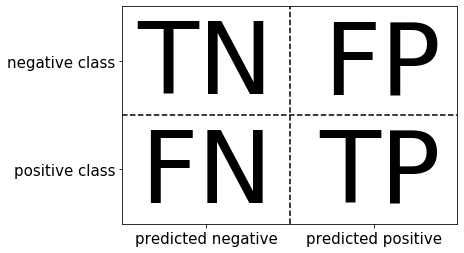

In [32]:
mglearn.plots.plot_binary_confusion_matrix()
plt.show()

我们用混淆矩阵来比较前面拟合过的模型(两个虚拟模型、决策树和Logistic回归）：

In [33]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[362  41]
 [ 40   7]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


观察混淆矩阵，很明显可以看出：
1. `pred_most_frequent`有问题，因为它总是预测同一个类别
2. `pred_dummy`的真正例数量很少，特别是与假反例和假正例的数量相比——假正例的数量竟然比真正例还多
3. 决策树的预测比虚拟预测更有意义，即使二者精度几乎相同
4. `Logistic回归`在各方面都比`pred_tree`要好：它的真正例和真反例的数量更多，而假正例和假反例的数量更少

从这个对比中可以明确看出，只有决策树和`Logistic回归`给出了合理的结果，并且`Logistic回归`的效果全面好于决策树。但是，检查整个混淆矩阵有点麻烦，虽然我们通过观察矩阵的各个方面得到了很多深入见解，但是这个过程是人工完成的，也是非常定性的。有几种方法可以总结混淆矩阵中包含的信息，我们将在后面进行讨论。

##### 与精度的关系
我们已经讲过一种总结混淆矩阵结果的方法——计算精度，其公式表达如下所示：
- $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

即`精度`是正确预测的数量(TP和TN)除以所有样本的数量(混淆矩阵中所有元素的总和)。

##### 准确率、召回率与 f-分数
`准确率`(precision)度量的是被预测为正例的样本中有多少是真正的正例：
- $Precision=\frac{TP}{TP+FP}$

如果目标是限制假正例的数量，那么可以使用`准确率`作为性能指标。举个例子，预测一种新药在临床试验治疗中是否有效。众所周知，临床试验非常昂贵，制药公司只有在非常确定药物有效的情况下才会进行试验。因此，模型不会产生很多假正例是很重要的——换句话说，模型的准确率很高。`准确率`也被称为`阳性预测值`(positive predictive value，PPV)。

`召回率`(recall)度量的是正类样本中有多少被预测为正类：
- $Recall=\frac{TP}{TP+FN}$

如果我们需要找出所有的正类样本，即避免假反例是很重要的情况下，那么可以使用`召回率`作为性能指标。癌症诊断例子就是一个很好的例子：找出所有患病的人很重要，预测结果中可能包含健康的人。`召回率`也叫`真正例率`(true positive rate，TPR)。

在优化`召回率`与`准确率`之间需要折中。如果你预测所有样本都属于正类，那么可以轻松得到完美的`召回率`——没有假反例，也没有真反例。但是，将所有样本都预测为正类，将会得到许多假正例，因此`准确率`会很低。与之相反，如果你的模型只将一个最确定的数据点预测为正类，其他点都预测为反类，那么`准确率`将会很完美(假设这个数据点实际上就属于正类)，但是`召回率`会非常差。

仅查看`准确率`和`召回率`二者之一无法为你提供完整的图景。将两种度量进行汇总的一种方法是 `f-分数`(f-score)或`f-度量`(f-measure)，它是准确率与召回率的调和平均：
- $F=2\cdot\frac{precision\cdot recall}{precision+recall}$

这一特定变体也被称为`f1-分数`(f1-score)。由于同时考虑了`准确率`和`召回率`，所以它对于不平衡的二分类数据集来说是一种比精度更好的度量：

In [34]:
print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.15
f1 score tree: 0.55
f1 score logistic regression: 0.89


这里我们可以注意到两件事情：
- 第一，我们从`most_frequent`的预测中得到一条错误信息，因为预测的正类数量为$0$(使得 `f-分数`的分母为$0$)
- 第二，我们可以看到虚拟预测与决策树预测之间有很大的区别，而仅观察精度时二者的区别并不明显

利用`f-分数`进行评估，我们再次用一个数字总结了预测性能。但是，`f-分数`似乎比精度更加符合我们对好模型的直觉。然而，`f-分数`的一个缺点是比精度更加难以解释。

使用`classification_report`函数可以同时计算这三个值，并以美观的格式打印出来：

In [35]:
print(classification_report(y_test, pred_most_frequent, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



`classification_report`函数为每个类别生成一行，并给出以该类别作为正类的`准确率`、`召回率`和`f-分数`。前面我们假设较少的“9”类是正类。如果将正类改为“not nine”(非9)，我们可以从`classification_report`的输出中看出，利用`most_frequent`模型得到的`f-分数`为$0.94$。此外，对于“not nine”类别，`召回率`是$1$，因为我们将所有样本都分类为“not nine”。`f-分数`旁边的最后一列给出了每个类别的`支持`(support)，它表示的是在这个类别中真实样本的数量。

分类报告的最后一行显示的是对应指标的加权平均(按每个类别中的样本个数加权)。下面还有两个报告，一个是虚拟分类器的，一个是`Logistic回归`的：

In [36]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      0.90      0.90       403
        nine       0.15      0.15      0.15        47

    accuracy                           0.82       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.82      0.82      0.82       450



In [37]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

    accuracy                           0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



在查看报告时你可能注意到了，虚拟模型与好模型之间的区别不再那么明显。选择哪个类作为正类对指标有很大影响。虽然在以“nine”类作为正类时虚拟分类的`f-分数`是$0.10$(对比`Logistic回归`的$0.894$)，而以“not nine”类作为正类时二者的`f-分数`分别是$0.91$和$0.99$，两个结果看起来都很合理。不过同时查看所有数字可以给出非常准确的图像，我们可以清楚地看到`Logistic`回归模型的优势。


#### 5.3.2.4 考虑不确定性
混淆矩阵和分类报告为一组特定的预测提供了非常详细的分析。但是，预测本身已经丢弃了模型中包含的大量信息。大多数分类器都提供了一个`decision_function`或`predict_proba`方法来评估预测的不确定度。预测可以被看作是以某个固定点作为`decision_function`或`predict_proba`输出的阈值——在二分类问题中，我们使用$0$作为决策函数的阈值，$0.5$作为`predict_proba`的阈值。

下面是一个不平衡二分类任务的示例，反类中有$400$个点，而正类中只有$50$个点。训练数据如`图5-12`左侧所示。我们在这个数据上训练一个核 SVM 模型，训练数据右侧的图像将决策函数值绘制为热图。你可以在图像偏上的位置看到一个黑色圆圈，表示`decision_function`的阈值刚好为$0$。在这个圆圈内的点将被划为正类，圆圈外的点将被划为反类：

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


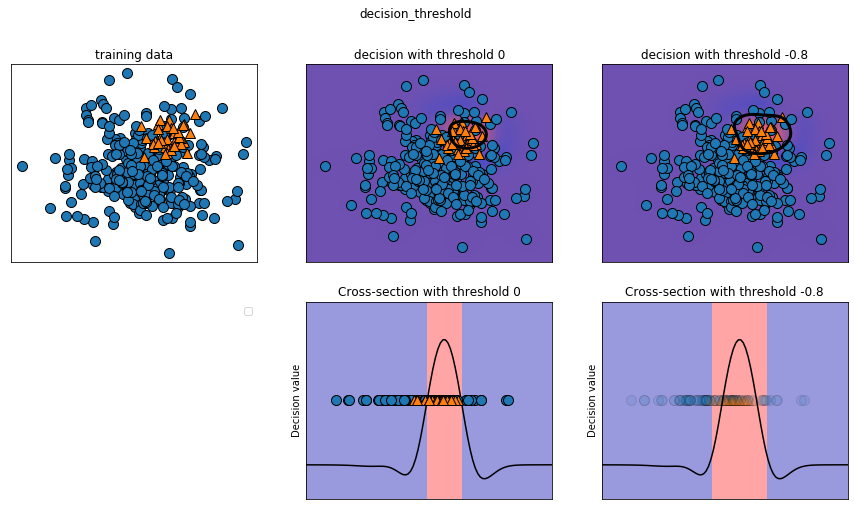

In [38]:
# 注意：这里的make_blobs不是sklearn.datasets下的make_blobs函数
X, y = mglearn.datasets.make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
mglearn.plots.plot_decision_threshold()
plt.show()

我们可以使用`classification_report`函数来评估两个类别的准确率与召回率：

In [39]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



对于`类别1`，我们得到了一个相当低的准确率，而召回率则令人糊涂(mixed)。由于`类别0`要大得多，所以分类器将重点放在将`类别0`分类正确，而不是较小的`类别1`。

假设在我们的应用中，`类别1`具有高召回率更加重要，正如前面的癌症筛查例子那样。这意味着我们愿意冒险有更多的假正例(假的`类别1`)，以换取更多的真正例(可增大召回率)。`svc.predict`生成的预测无法满足这个要求，但我们可以通过改变决策阈值来将预测重点放在使`类别1`的召回率更高。默认情况下，`decision_function`值大于$0$的点将被划为`类别1`。我们希望将更多的点划为`类别1`，所以需要减小阈值：

In [40]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



正如所料，`类别1`的召回率增大，准确率减小。如果你认为准确率比召回率更重要，或者反过来，或者你的数据严重不平衡，那么改变决策阈值是得到更好结果的最简单方法。由于`decision_function`的取值可能在任意范围，所以很难提供关于如何选取阈值的经验法则。

> 如果你设置了阈值，那么要小心不要在测试集上这么做。与其他任何参数一样，在测试集上设置决策阈值可能会得到过于乐观的结果。可以使用验证集或交叉验证来代替。

对于实现了`predict_proba`方法的模型来说，选择阈值可能更简单，因为`predict_proba`的输出固定在$0$到$1$的范围内，表示的是概率。默认情况下，$0.5$的阈值表示，如果模型以超过$50\%$的概率“确信”一个点属于正类，那么就将其划为正类。增大这个阈值意味着模型需要更加确信才能做出正类的判断(较低程度的确信就可以做出反类的判断)。并非所有模型都提供了不确定性的实际模型(一棵生长到最大深度的`DecisionTree`总是$100\%$确信其判断，即使很可能是错的)。这与校准(calibration)的概念相关：校准模型是指能够为其不确定性提供精确度量的模型。校准的详细讨论超出了本书的范围，但你可以在[Alexandru Niculescu-Mizil 和 Rich Caruana 的“Predicting Good Probabilities with Supervised Learning”](http://www.machinelearning.org/proceedings/icml2005/papers/079_GoodProbabilities_NiculescuMizilCaruana.pdf)这篇文章中找到更多内容。

#### 5.3.2.5 准确率-召回率曲线
改变模型中用于做出分类决策的阈值，是一种调节给定分类器的准确率和召回率之间折中的方法。你可能希望仅遗漏不到$10\%$的正类样本，即希望召回率能达到$90\%$。这一决策取决于应用，应该是由商业目标驱动的。一旦设定了一个具体目标，就可以适当地设定一个阈值。总是可以设置一个阈值来满足特定的目标，比如$90\%$的召回率。难点在于开发一个模型，在满足这个阈值的同时仍具有合理的准确率——如果你将所有样本都划为正类，那么将会得到$100\%$的召回率，但你的模型毫无用处。

对分类器设置要求(比如$90\%$的召回率)通常被称为设置工作点(operating point)。在业务中固定工作点通常有助于为客户或组织内的其他小组提供性能保证。

在开发新模型时，通常并不完全清楚工作点在哪里。因此，为了更好地理解建模问题，很有启发性的做法是，同时查看所有可能的阈值或准确率和召回率的所有可能折中。利用一种叫作`准确率-召回率曲线`(precision-recall curve)的工具可以做到这一点。你可以在`sklearn.metrics`模块中找到计算`准确率-召回率曲线`的函数。这个函数需要真实标签与预测的不确定度，后者由`decision_function`或`predict_proba`给出：

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


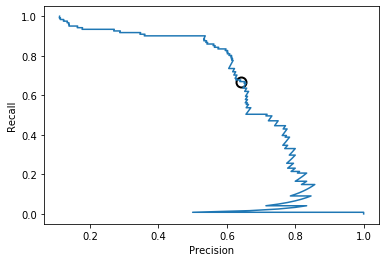

In [41]:
# precision_recall_curve()返回一个列表，包含按顺序排序的所有可能阈值(在决策函数中出现的所有值)
# 对应的准确率和召回率，这样我们就可以绘制一条曲线

# 使用更多数据点来得到更加平滑的曲线
X, y = mglearn.datasets.make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

# 找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds))

plt.plot(precision[close_zero], recall[close_zero], 'o', 
         markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

图中曲线上的每一个点都对应`decision_function`的一个可能的阈值。例如，我们可以看到，在准确率约为$0.75$的位置对应的召回率为$0.4$。黑色圆圈表示的是阈值为$0$的点，$0$是`decision_function`的默认阈值。这个点是在调用`predict`方法时所选择的折中点。

曲线越靠近右上角，则分类器越好。右上角的点表示对于同一个阈值，准确率和召回率都很高。曲线从左上角开始，这里对应于非常低的阈值，将所有样本都划为正类。提高阈值可以让曲线向准确率更高的方向移动，但同时召回率降低。继续增大阈值，大多数被划为正类的点都是真正例，此时准确率很高，但召回率更低。随着准确率的升高，模型越能够保持较高的召回率，则模型越好。

进一步观察这条曲线，可以发现，利用这个模型可以得到约$0.5$的准确率，同时保持很高的召回率。如果我们想要更高的准确率，那么就必须牺牲很多召回率。换句话说，曲线左侧相对平坦，说明在准确率提高的同时召回率没有下降很多。当准确率大于$0.5$之后，准确率每增加一点都会导致召回率下降许多。

不同的分类器可能在曲线上不同的位置(即在不同的工作点)表现很好。我们来比较一下在同一数据集上训练的`SVM`与`随机森林`。`RandomForestClassifier`没有`decision_function`，只有`predict_proba`。`precision_recall_curve`函数的第二个参数应该是正类的确定性度量，所以我们传入样本属于`类别1`的概率。二分类问题的`predict_proba`的默认阈值是`0.5`，所以我们在曲线上标出这个点(见`图5-14`)：

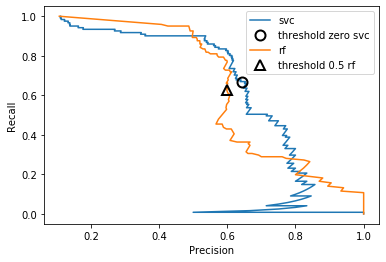

In [42]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier有predict_proba，但没有decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

从这张对比图中可以看出，`随机森林`在极值处(要求很高的召回率或很高的准确率)的表现更好。在中间位置(准确率约为$0.7$)`SVM`的表现更好。如果我们只查看`f1-分数`来比较二者的总体性能，那么可能会遗漏这些细节。`f1-分数`只反映了`准确率-召回率曲线`上的一个点，即默认阈值对应的那个点：

In [43]:
print("f1_score of random forest: {:.3f}".format(f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


比较这两条`准确率-召回率曲线`，可以为我们提供大量详细的洞见，但这是一个相当麻烦的过程。对于自动化模型对比，我们可能希望总结曲线中包含的信息，而不限于某个特定的阈值或工作点。总结`准确率-召回率曲线`的一种方法是计算该曲线下的积分或面积，也叫作`平均准确率`(average precision)。使用 `average_precision_score`函数来计算平均准确率。因为我们要计算`准确率-召回率曲线`并考虑多个阈值，所以需要向`average_precision_score`传入`decision_function`或`predict_proba`的结果，而不是`predict`的结果：

In [44]:
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


在对所有可能的阈值进行平均时，我们看到`随机森林`和`SVC`的表现差不多好，随机森林稍稍领先(*注：我得到的结果和书中不一样，是SVC略好*)。这与前面从`f1_score`中得到的结果大为不同。因为平均准确率是从$0$到$1$的曲线下的面积，所以平均准确率总是返回一个在$0$(最差)到$1$(最好)之间的值。随机分配`decision_function`的分类器的平均准确率是数据集中正例样本所占的比例。

#### 5.3.2.6 受试者工作特征(ROC)与AUC
还有一种常用的工具可以分析不同阈值的分类器行为：受试者工作特征曲线(receiver operating characteristics curve)，简称为`ROC曲线`(ROC curve)。`ROC曲线`考虑了给定分类器的所有可能的阈值，但它显示的是假正例率(false positive rate，FPR)和真正例率(true positive rate，TPR)，而不是报告准确率和召回率。回想一下，真正例率只是召回率的另一个名称，而假正例率则是假正例占所有反类样本的比例：
- $FPR = \frac{FP}{FP+TN}$

可以用`roc_curve`函数来计算`ROC曲线`(见`图5-15`)：

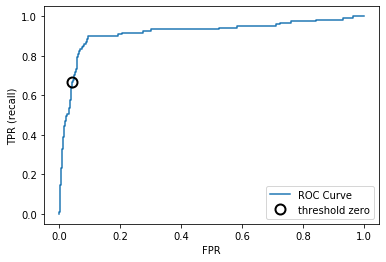

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# 找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

对于`ROC曲线`，理想的曲线要靠近左上角：你希望分类器的召回率很高，同时保持假正例率很低。从曲线中可以看出，与默认阈值$0$相比，我们可以得到明显更高的召回率(约$0.9$)，而`FPR`仅稍有增加。最接近左上角的点可能是比默认选择更好的工作点。同样请注意，不应该在测试集上选择阈值，而是应该在单独的验证集上选择。

`图5-16`给出了`随机森林`和`SVM`的`ROC曲线`对比：

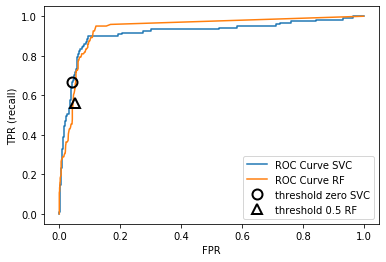

In [46]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
plt.show()

与`准确率-召回率曲线`一样，我们通常希望使用一个数字来总结`ROC曲线`，即曲线下的面积，通常被称为`AUC`(area under the curve)。我们可以利用`roc_auc_score`函数来计算`ROC曲线`下的面积：

In [47]:
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


利用`AUC`比较随机森林和SVM，我们发现随机森林的表现比SVM要略好一些。回想一下，由于平均准确率是从$0$到$1$的曲线下的面积，所以平均准确率总是返回一个$0$(最差)到$1$(最好)之间的值。随机预测得到的`AUC`总是等于$0.5$，无论数据集中的类别多么不平衡。对于不平衡的分类问题来说，`AUC`是一个比精度好得多的指标。`AUC`可以被解释为评估正例样本的排名(ranking)。它等价于从正类样本中随机挑选一个点，由分类器给出的分数比从反类样本中随机挑选一个点的分数更高的概率。因此，`AUC`最高为$1$，这说明所有正类点的分数高于所有反类点。对于不平衡类别的分类问题，使用`AUC`进行模型选择通常比使用精度更有意义。

我们回到前面研究过的例子：将`digits数据集`中的所有$9$与所有其他数据加以区分。我们将使用`SVM`对数据集进行分类，分别使用三种不同的内核宽度(gamma)设置(参见`图5-17`)：

gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


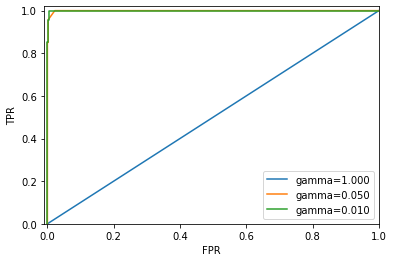

In [48]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}".format(
    gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

对于三种不同的`gamma`设置，其精度是相同的。这可能与随机选择的性能相同，也可能不同。但是观察`AUC`以及对应的曲线，我们可以看到三个模型之间有明显的区别。对于$gamma=1.0$，`AUC`实际上处于随机水平，即`decision_function`的输出与随机结果一样好。对于$gamma=0.05$，性能大幅提升至`AUC`等于$0.9$。最后，对于$gamma=0.01$，我们得到等于$1.0$的完美`AUC`(仔细观察$gamma=0.01$的曲线，你可以看到左上角有一个很小的弯曲。这说明至少有一个点的排名是错的。`AUC`等于$1.0$是舍入到第二位小数的结果)。这意味着根据决策函数，所有正类点的排名要高于所有反类点。换句话说，利用正确的阈值，这个模型可以对所有数据进行完美分类！知道这一点，我们可以调节这个模型的阈值并得到很好的预测结果。如果我们仅使用精度，那么将永远不会发现这一点。

**因此，我们强烈建议在不平衡数据上评估模型时使用`AUC`。但请记住，`AUC`没有使用默认阈值，因此，为了从高`AUC`的模型中得到有用的分类结果，可能还需要调节决策阈值。**

### 5.3.3 多分类指标
多分类问题的所有指标基本上都来自于二分类指标，但是要对所有类别进行平均。多分类的精度被定义为正确分类的样本所占的比例。同样，如果类别是不平衡的，精度并不是很好的评估度量。想象一个三分类问题，其中$85\%$的数据点属于类别A，$10\%$属于类别B，$5\%$属于类别 C。在这个数据集上$85\%$的精度说明了什么？一般来说，多分类结果比二分类结果更加难以理解。除了精度，常用的工具有混淆矩阵和分类报告。下面我们将这两种详细的评估方法应用于对`digits数据集`中$10$种不同的手写数字进行分类的任务：

In [49]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


模型的精度为$95.3\%$，这表示我们已经做得相当好了。混淆矩阵为我们提供了更多细节。与二分类的情况相同，每一行对应于真实标签，每一列对应于预测标签。`图5-18`给出了一张视觉上更加吸引人的图像：

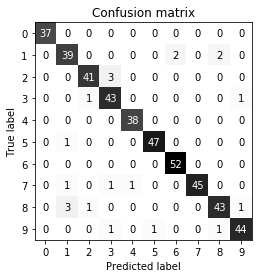

In [50]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

对于第一个类别(数字0)，37个样本都被划为类别0。我们还可以看到，没有其他数字被误分类为类别0，这是因为混淆矩阵第一列中其他所有元素都为0。但是有些数字与其他数字混在一起，比如数字2(第3行)，其中有3个被划分到数字3中(第4列)。还有一个数字3被划分到数字2中，一个数字8被划分到数字2中。

利用`classification_report`函数，我们可以计算每个类别的准确率、召回率和f-分数：

In [51]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



对于多分类问题中的不平衡数据集，最常用的指标就是多分类版本的`f-分数`。`多分类f-分数`背后的想法是，对每个类别计算一个二分类`f-分数`，其中该类别是正类，其他所有类别组成反类。然后，使用以下策略之一对这些按类别`f-分数`进行平均：
- “宏”(macro)平均：计算未加权的按类别f-分数。它对所有类别给出相同的权重，无论类别中的样本量大小
- “加权”(weighted)平均：以每个类别的支持作为权重来计算按类别f-分数的平均值。分类报告中给出的就是这个值
- “微”(micro)平均：计算所有类别中假正例、假反例和真正例的总数，然后利用这些计数来计算准确率、召回率和f-分数

如果你对每个样本等同看待，那么推荐使用“微”平均f1-分数；如果你对每个类别等同看待，那么推荐使用“宏”平均f1-分数：

In [52]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


### 5.3.4 回归指标
对回归问题可以像分类问题一样进行详细评估，例如，对目标值估计过高与目标值估计过低进行对比分析。但是，对于我们见过的大多数应用来说，使用默认$R^2$就足够了，它由所有回归器的`score`方法给出。业务决策有时是根据均方误差或平均绝对误差做出的，这可能会鼓励人们使用这些指标来调节模型。但是一般来说，我们认为$R^2$是评估回归模型的更直观的指标。



### 5.3.5 在模型选择中使用评估指标
前面详细讨论了许多种评估方法，以及如何根据真实情况和具体模型来应用这些方法。但我们通常希望，在使用`GridSearchCV`或`cross_val_score`进行模型选择时能够使用`AUC`等指标。幸运的是，`scikit-learn`提供了一种非常简单的实现方法，就是`scoring`参数，它可以同时用于`GridSearchCV`和`cross_val_score`。你只需提供一个字符串，用于描述想要使用的评估指标：

In [53]:
# 分类问题的默认评分是精度
print("Default scoring: {}".format(cross_val_score(SVC(), digits.data, digits.target == 9)))

# 指定"scoring="accuracy"不会改变结果
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9,scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))

roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9, scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.89983306 0.89983306 0.89983306]
Explicit accuracy scoring: [0.89983306 0.89983306 0.89983306]
AUC scoring: [0.99372294 0.98957947 0.99594929]


类似地，我们可以改变`GridSearchCV`中用于选择最佳参数的指标：

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# 我们给出了不太好的网格来说明：
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# 使用默认的精度：
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973


In [55]:
# 使用AUC评分来代替：
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))


Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


在使用精度时，选择的参数是$gamma=0.0001$，而使用`AUC`时选择的参数是$gamma=0.01$。在两种情况下，交叉验证精度与测试集精度是一致的。但是，使用`AUC`找到的参数设置，对应的`AUC`更高，甚至对应的精度也更高。

> 利用 AUC 找到了精度更高的模型，这可能是因为对于不平衡数据来说，精度并不是模型性能的良好度量。

对于分类问题，`scoring`参数最重要的取值包括：`accuracy`、`roc_auc`、`average_precision`、`f1`、`f1_macro`、`f1_micro`和`f1_weighted`。对于回归问题，最常用的取值包括：`r2`、`mean_squared_error`和`mean_absolute_error`。你可以在文档中找到所[支持参数的完整列表](http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)，也可以查看`metrics.scorer`模块中定义的`SCORER`字典：

In [56]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


## 5.4 小结与展望
本章讨论了交叉验证、网格搜索和评估指标等内容，它们是评估与改进机器学习算法的基础。本章介绍的工具，以及第2、3章介绍的算法，是每位机器学习从业者赖以生存的工具。

本章有两个特别的要点，这里需要重复一下，因为它们经常被新的从业人员所忽视。第一个要点与交叉验证有关。交叉验证或者使用测试集让我们可以评估一个机器学习模型未来的表现。但是，如果我们使用测试集或交叉验证来选择模型或选择模型参数，那么我们就“用完了”测试数据，而使用相同的数据来评估模型未来的表现将会得到过于乐观的估计。因此，我们需要将数据集划分为训练数据、验证数据与测试数据，其中训练数据用于模型构建，验证数据用于选择模型与参数，测试数据用于模型评估。我们可以用交叉验证来代替每一次简单的划分。最常用的形式是训练/测试划分用于评估，然后对训练集使用交叉验证来选择模型与参数。

第二个要点与用于模型选择与模型评估的评估指标或评分函数有关。如何利用机器学习模型的预测结果做出商业决策，其理论有些超出了本书范围。但是，机器学习任务的最终目标很少是构建一个高精度的模型。一定要确保你用于模型评估与选择的指标能够很好地替代模型的实际用途。在实际当中，分类问题很少会遇到平衡的类别，假正例和假反例也通常具有非常不同的后果。你一定要了解这些后果，并选择相应的评估指标。我们强烈推荐阅读`Foster Provost`和`Tom Fawcett`的《Data Science for Business(O'Reilly)》 一书来了解关于这一主题的更多信息。

到目前为止，我们介绍的模型评估与选择技术都是数据科学家工具箱中最重要的工具。本章介绍的网格搜索与交叉验证只能应用于单个监督模型。但是我们前面看到，许多模型都需要预处理，在某些应用中，提取数据的不同表示是很有用的。下一章我们将会介绍`Pipeline`类，它允许我们在这些复杂的算法链上使用网格搜索与交叉验证。